# Variational Autoencoder

source :https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

Variational autoencoders are a slightly more modern and interesting take on autoencoding.


What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a _latent variable model_ for its input data.  
So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".


#### How does a variational autoencoder work?

First, an encoder network turns the input samples `x` into two parameters in a latent space, which we will note `z_mean` and `z_log_sigma`. Then, we randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via   

    z = z_mean + exp(z_log_sigma) * epsilon  

, where `epsilon` is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.


The parameters of the model are trained via two loss functions: 
  - a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and 
  - the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [17]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs=50
epsilon_std = 1.0

In [5]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [8]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        
        return x

In [13]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop',
            loss=None)

/Users/hongta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.
  after removing the cwd from sys.path.


In [14]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [18]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 190.2092 - val_loss: 172.5402
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 169.9900 - val_loss: 167.9878
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 166.6995 - val_loss: 165.4716
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 164.6537 - val_loss: 164.0935
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 163.1621 - val_loss: 162.8463
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 161.9171 - val_loss: 161.6327
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 160.7819 - val_loss: 160.5169
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 159.7205 - val_loss: 159.6492
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 158.7372 - val_loss: 158.6479
Epoch 10/50
60000/60000 [==============================] - 

In [19]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

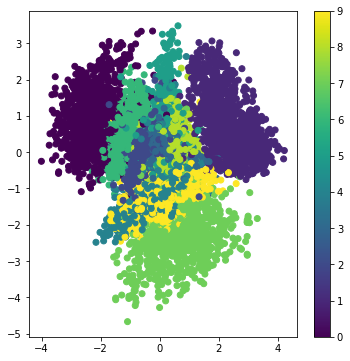

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [21]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [24]:
from scipy.stats import norm

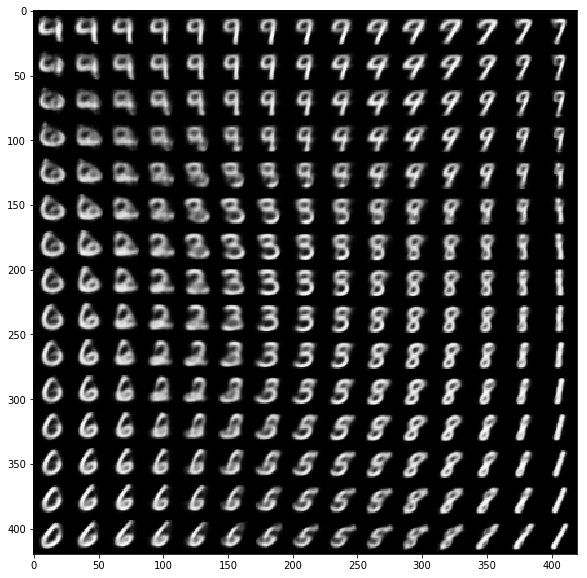

In [25]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i+1) * digit_size,
               j * digit_size: (j+1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()